# Простые классификаторы MNIST. Часть 3. Сверточные архитектуры.

Пример обучения сверточных сетей для классификации изображений MNIST. 

In [11]:
import keras
from keras.regularizers import l1_l2 # Регуляризаторы
from keras.datasets import mnist # Датасет
from keras.models import Sequential # Базовый класс для создания нейронной сети
from keras.layers import Flatten, Dense # Два вида слоёв нейронное сети, которые будут использоваться
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, LeakyReLU
from keras.utils import np_utils # Утилиты для one-hot encoding
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt

print(keras.__version__)

2.3.1


Загрузим данные.

In [4]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Как мы уже знаем, изображения в нашем датасете представляют из себя матрицы 28 на 28. Сверточные же слои в keras устроены таким образом, чтобы удобно работать с rgb-изображениями и т.п., которые представляют из себя несколько матриц или трехмерного тензора. Чтобы соответствовать данному требованию, добавим одну размерность к нашим изображениям, чтобы получилось 28 на 28 на 1. Фактически, это то же самое, что и 28 на 28, но тензоры данного вида можно подавать в сверточную сеть.

In [5]:
train_images = train_images.reshape(60000, 28, 28, 1)
test_images = test_images.reshape(10000, 28, 28, 1)

Кроме того, подготовим данные так же, как и в предыдущих примерах.

In [6]:
train_images = train_images / 255.0
test_images = test_images / 255.0

validation_images = train_images[:1000]
validation_labels = train_labels[:1000]

train_images = train_images[1000:]
train_labels = train_labels[1000:]

Аугментация данных.

In [12]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

In [13]:
datagen.fit(train_images)

Сверточная сеть.

In [24]:
model = Sequential([
    Conv2D(32, (3, 3), kernel_regularizer=l1_l2(l1=1e-4, l2=1e-3), input_shape=(28, 28, 1)),
    LeakyReLU(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), kernel_regularizer=l1_l2(l1=1e-4, l2=1e-3)),
    LeakyReLU(),
    Conv2D(64, (3, 3), kernel_regularizer=l1_l2(l1=1e-4, l2=1e-3)),
    LeakyReLU(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(64, kernel_regularizer=l1_l2(l1=1e-4, l2=1e-3)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.4),
    
    Dense(10, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 9, 9, 64)         

In [25]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
EPOCHS = 25
BATCH_SIZE = 64

history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE),
    steps_per_epoch=len(train_images) / BATCH_SIZE, 
    epochs=EPOCHS,
    validation_data=(validation_images, validation_labels)
)

Epoch 1/25
922/921 [==============================] - 42s 45ms/step - loss: 1.3598 - accuracy: 0.5448 - val_loss: 0.7472 - val_accuracy: 0.7880
Epoch 2/25
922/921 [==============================] - 41s 44ms/step - loss: 0.8928 - accuracy: 0.7247 - val_loss: 0.7042 - val_accuracy: 0.8120
Epoch 3/25
922/921 [==============================] - 42s 46ms/step - loss: 0.7431 - accuracy: 0.7822 - val_loss: 0.8954 - val_accuracy: 0.7520
Epoch 4/25
922/921 [==============================] - 44s 47ms/step - loss: 0.6806 - accuracy: 0.8052 - val_loss: 0.5217 - val_accuracy: 0.8610
Epoch 5/25
922/921 [==============================] - 41s 45ms/step - loss: 0.6428 - accuracy: 0.8215 - val_loss: 0.4267 - val_accuracy: 0.8900
Epoch 6/25
922/921 [==============================] - 41s 45ms/step - loss: 0.6166 - accuracy: 0.8326 - val_loss: 0.4160 - val_accuracy: 0.9140
Epoch 7/25
922/921 [==============================] - 42s 46ms/step - loss: 0.6069 - accuracy: 0.8375 - val_loss: 0.9960 - val_accuracy:

Оценим точность и выведем историю обучения.

In [27]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nТочность на проверочных данных:', test_acc)


Точность на проверочных данных: 0.925000011920929


In [28]:
def show_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

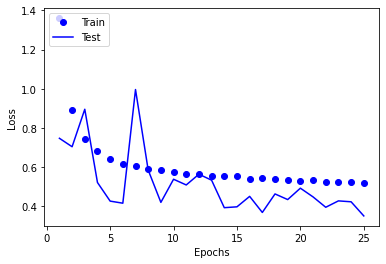

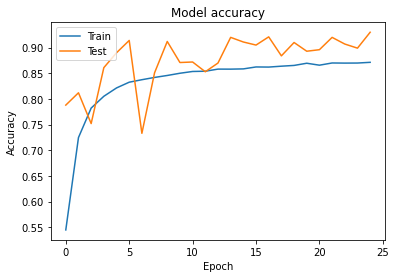

In [29]:
show_loss(history)

На самом деле точность - не самая показательная метрика. Представим себе, что данные состоят на 99% из класса 1, и на 1% из класса 2, а модель выдает константу - класс 1. Мы будем видеть точность 99%, но на самом деле модель работает очень плохо. Для решения этой проблемы стоит использовать более показательные метрики, например, f1 score.

В данном примере воспользуемся так называемой confusion matrix, которая будет более детально описывать выводы модели. Идея простая: строки матрицы будут отвечать за класс, а столбцы за то, с какой частотой этот класс принимается за другой. В идеальном случае матрица будет единичной.

In [2]:
import itertools
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
        cm (array, shape = [n, n]): a confusion matrix of integer classes
        class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

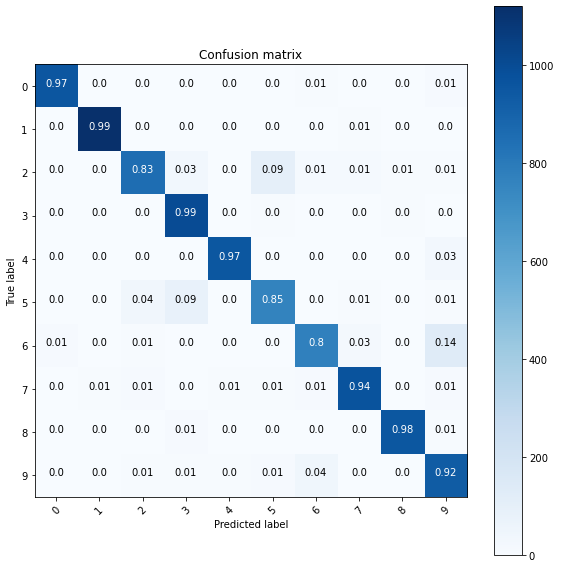

In [31]:
pred_labels = model.predict(test_images)

from sklearn import metrics
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
con_mat = metrics.confusion_matrix(test_labels, pred_labels.argmax(axis=1))

plot_confusion_matrix(con_mat, class_names)
plt.show()

В примере выше мы видим, что цифру 6 с частотой 0.8 модель распознает правильно, а в 0.14 случаях как 9. Можно сделать предположение, что данная проблема вызвана поворотами и отражениями при аугментации данных, ведь при достаточном повороте цифра 9 превращается в 6 и наоборот.

Таким образом, с помощью несложной визуализации мы теперь отчетливо видим, какой класс плохо распознается, с какими другими классами его путает модель и т.д. 